# Multi-step model
We start by importing usefull modules and checking if we have the correct versions installed.

In [1]:
import tensorflow as tf

import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# min-maxScaler
from sklearn.preprocessing import MinMaxScaler

# To plot
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Here we import the data, the first comments is an example of how we import the data on mac, the second on windows.

In [2]:
# "/Users/vasileioskilis/Desktop/projectA1988/dataset/GOOGL5yearsd.csv"
# "C:\\Users\\KILDE\\Desktop\\projectA\\dataset\\GOOGL5yearsd.csv"

stock=pd.read_csv("C:\\Users\\KILDE\\Desktop\\vxk969\\dataset\\AAPL_.csv")
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-06-09,26.398571,26.420000,25.107143,25.944286,22.459904,472098200
1,2008-06-10,25.787144,26.682858,25.574286,26.520000,22.958296,285235300
2,2008-06-11,26.334286,26.571428,25.655714,25.830000,22.360960,240387700
3,2008-06-12,25.927143,26.085714,24.457144,24.751429,21.427246,327083400
4,2008-06-13,24.520000,24.879999,23.615715,24.624287,21.317177,336489300


# We create a panada series, with Data as an index to the closing price and plot it

In [3]:
close_price = stock['Close']
close_price.index = stock['Date']
close_price.head()

Date
2008-06-09    25.944286
2008-06-10    26.520000
2008-06-11    25.830000
2008-06-12    24.751429
2008-06-13    24.624287
Name: Close, dtype: float64

# Reshape close price and scale the data

In [4]:
close_price = stock.Close.values

In [5]:
close_price = np.reshape(close_price,(-1,1))

In [6]:
scaler = MinMaxScaler()
data_normalised = scaler.fit_transform(close_price)

# We split the dataset into 80% train, 10% validation and 10% test

In [7]:
train_size = int(len(data_normalised) * 0.80)
half_rest = int((len(data_normalised) - train_size)/2)

train_set = data_normalised[0:train_size,:]
val_set = data_normalised[train_size:train_size+half_rest,:]
test_set = data_normalised[train_size+half_rest:len(data_normalised),:]

# Method that creates sliding windows

In [8]:
def createBigWindows(dataset, window , predictionAmount):
    X_train = []
    Y_train = []
    
    for i in range(len(dataset)-window-1):
        X_train.append(dataset[i:(i+window)-predictionAmount,0])
        Y_train.append(dataset[((i+window)-predictionAmount):i+window,0])
    return np.array(X_train),np.array(Y_train)

# Here we choose window size and how many steps ahed we want to predict

In [9]:
fututePredictionNumber = 5
windowsSize = 20

In [10]:
X_train, Y_train = createBigWindows(train_set,windowsSize,fututePredictionNumber)

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [12]:
X_val, Y_val = createBigWindows(val_set,windowsSize,fututePredictionNumber)
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [13]:
X_test, Y_test = createBigWindows(test_set,windowsSize,fututePredictionNumber)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# We combine the X_train and Y_train to tensors and shuffle them, also we choose the batch size

In [14]:
BATCH_SIZE = 32
BUFFER_SIZE = 10000

suffleTrain = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
suffleTrain  = suffleTrain .cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

suffleVal = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
suffleVal = suffleVal.batch(BATCH_SIZE).repeat()

Here we were changing the learning's rate value for the experiments

In [15]:
 opt = tf.keras.optimizers.RMSprop(learning_rate=0.0008,clipvalue=1.0)

# Model and train the model
This is the best model we found

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(30, return_sequences=True, input_shape= X_train.shape[-2:]),
    tf.keras.layers.LSTM(30),
    tf.keras.layers.Dense(fututePredictionNumber)
])
model.compile(loss="mse", optimizer=opt)
history = model.fit(suffleTrain,epochs=15,steps_per_epoch=200,validation_data=suffleVal,validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/15
200/200 [==============================] - 6s 32ms/step - loss: 0.0202 - val_loss: 0.0018
Epoch 2/15
200/200 [==============================] - 1s 3ms/step - loss: 5.8700e-04 - val_loss: 0.0059
Epoch 3/15
200/200 [==============================] - 1s 3ms/step - loss: 5.4070e-04 - val_loss: 0.0034
Epoch 4/15
200/200 [==============================] - 1s 3ms/step - loss: 5.2416e-04 - val_loss: 0.0035
Epoch 5/15
200/200 [==============================] - 1s 3ms/step - loss: 4.8149e-04 - val_loss: 0.0017
Epoch 6/15
200/200 [==============================] - 1s 3ms/step - loss: 4.6751e-04 - val_loss: 0.0018
Epoch 7/15
200/200 [==============================] - 1s 3ms/step - loss: 4.4128e-04 - val_loss: 0.0024
Epoch 8/15
200/200 [==============================] - 1s 3ms/step - loss: 4.3281e-04 - val_loss: 0.0032
Epoch 9/15
200/200 [==============================] - 1s 3ms/step - loss: 4.1133e-04 - val_loss: 0.0021
Epoch 10/15
200/200 [===

# Summary of the model and a tree scrature of the model

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 30)             5520      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 5)                 155       
Total params: 12,995
Trainable params: 12,995
Non-trainable params: 0
_________________________________________________________________


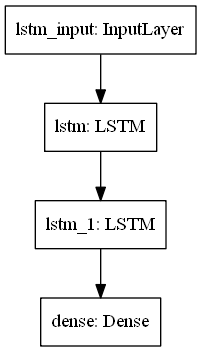

In [18]:
tf.keras.utils.plot_model(model)

# Plot some example windows

In [19]:
Y_pred = model.predict(X_train)

In [20]:
windowNO=0

In [21]:
y_pred = Y_pred[windowNO]
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1 ,)

In [22]:
y_true = Y_train[windowNO]
y_true= scaler.inverse_transform(y_true.reshape(-1, 1)).reshape(-1 ,)

In [23]:
X_true = X_train[windowNO]
X_true = scaler.inverse_transform(X_true.reshape(-1, 1)).reshape(-1 ,)


In [24]:
def plot(timeseries, real, prediction):
    plt.plot(timeseries.flatten(), ".-")
    time_steps = timeseries.shape
    if real is not None:
        plt.plot(time_steps, real,"bx", markersize=10)
    if prediction is not None:
        plt.plot (time_steps, prediction,'go')
    return plt

In [25]:
def create_time_steps(length):
  return list(range(-length, 0))

In [26]:
n_steps = 1

In [62]:
def multiPlot(history, true_future, prediction):
  plt.plot(create_time_steps(len(history)), np.array(history), label='Historical Data')
  plt.plot(np.arange(len(true_future)), np.array(true_future), 'bo',label='True Data')
  if prediction.any():
    plt.plot(np.arange(len(true_future)), np.array(prediction), 'go',label='Predictions')
  plt.legend(loc='upper right')
  plt.show()

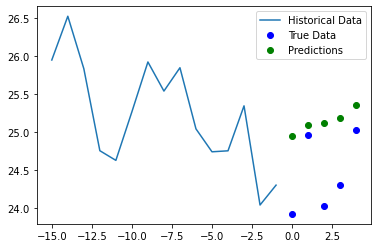

In [63]:
multiPlot(X_true, y_true, y_pred)

# Model evaluate on validation set

In [64]:
y_true_val= Y_val
y_true_val= scaler.inverse_transform(y_true_val.reshape(-1, 1)).reshape(-1 ,)

In [65]:
y_pred_val = model.predict(X_val).reshape(-1, )
y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1)).reshape(-1 ,)

In [66]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true_val, y_pred_val)

2.8259615819673964

In [67]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true_val, y_pred_val)

12.941102522826846

In [68]:
# root mean square error
from math import sqrt
rms = sqrt(mean_squared_error(y_true_val, y_pred_val))
rms

3.5973743929186526

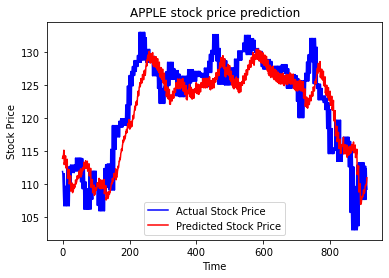

In [69]:
plt.plot(y_true_val, color = 'blue', label = 'Actual Stock Price')
plt.plot(y_pred_val, color = 'red', label = 'Predicted Stock Price')
plt.title('APPLE stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

#  Model evaluate on the test set

In [70]:
y_true_test = Y_test
y_true_test = scaler.inverse_transform(Y_test.reshape(-1, 1)).reshape(-1 ,)

In [71]:
y_pred_test = model.predict(X_test).reshape(-1, )
y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1)).reshape(-1 ,)

In [72]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true_test, y_pred_test)

2.638321838846909

In [73]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true_test, y_pred_test)

12.167728559509689

In [74]:
# root mean square error
rms = sqrt(mean_squared_error(y_true_test, y_pred_test))
rms

3.4882271370295954

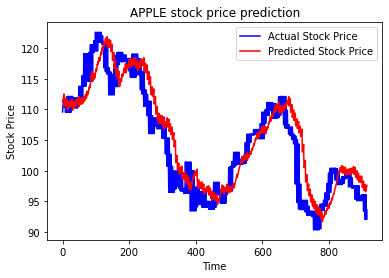

In [75]:
plt.plot(y_true_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(y_pred_test, color = 'red', label = 'Predicted Stock Price')
plt.title('APPLE stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# websites used to create this program

https://www.tensorflow.org/tutorials/structured_data/time_series